


# Analysing Human Movement Patterns and Counting in Diverse Environments using ``YOLOV8`` and ``Roboflow supervision``

---
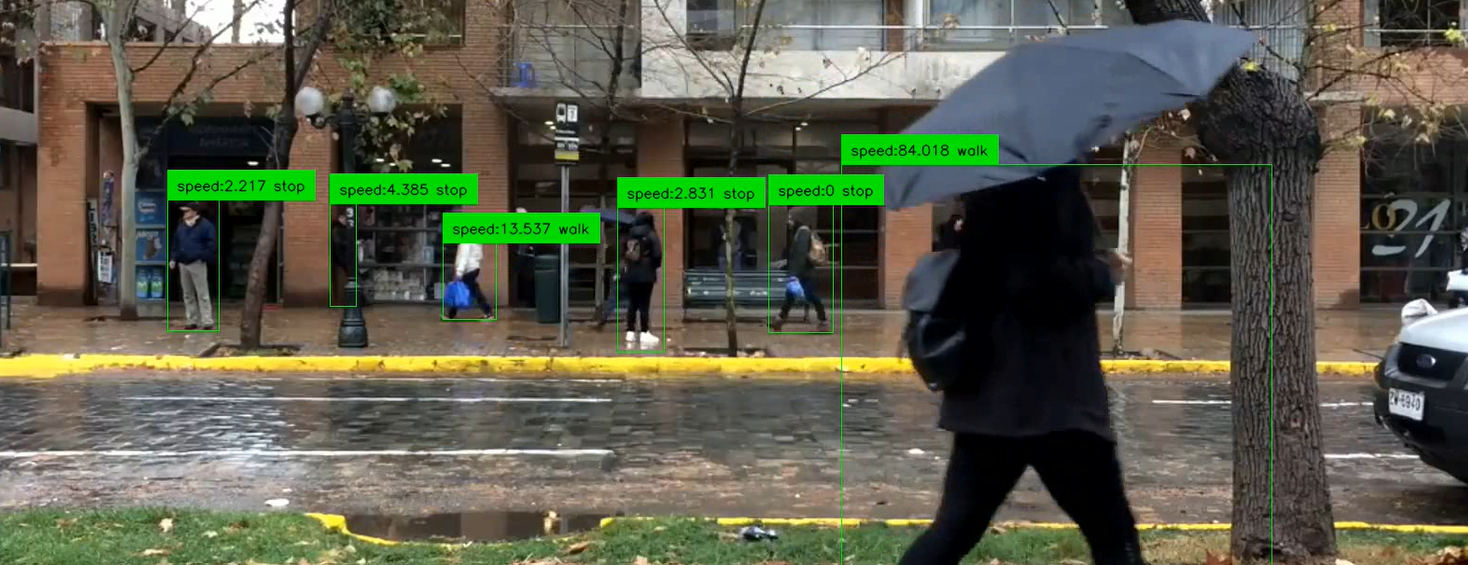
---

<a align="">
  <img width="600"src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png">
</a>

<a align="">
  <img width="600" src="https://camo.githubusercontent.com/8d64a0d2154d45961111842fff941b9f7ee5d822bb674e5366e50ea32f2bcbdc/68747470733a2f2f6d656469612e726f626f666c6f772e636f6d2f6f70656e2d736f757263652f7375706572766973696f6e2f72662d7375706572766973696f6e2d62616e6e65722e706e673f7570646174656441743d31363738393935393237353239">
</a>
<div align="center">
  <a href="https://github.com/ultralytics/ultralytics">
    <img src="https://github.com/ultralytics/hub/actions/workflows/ci.yaml/badge.svg" alt="CI CPU"></a>
  <a href="">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>





# Setup


Install `ultralytics` to Download, Train, Test, and Export Object detection models.

<a align="center">
  <img width="200" src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png">
</a>

In [1]:
%pip install ultralytics  # install
from IPython import display
display.clear_output()

Install `roboflow` for datasets downloading

In [2]:
%pip install roboflow
display.clear_output()

In [3]:
import os
import shutil
import numpy as np
import yaml
from roboflow import Roboflow
from ultralytics import YOLO, checks, hub
checks()  # checks

Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


## Objects Detection


## Install Supervision

<a align="center">
  <img width ="300" src="https://camo.githubusercontent.com/8d64a0d2154d45961111842fff941b9f7ee5d822bb674e5366e50ea32f2bcbdc/68747470733a2f2f6d656469612e726f626f666c6f772e636f6d2f6f70656e2d736f757263652f7375706572766973696f6e2f72662d7375706572766973696f6e2d62616e6e65722e706e673f7570646174656441743d31363738393935393237353239">
</a>

In [4]:
!pip install supervision==0.1.0
display.clear_output()

## Install ByteTrack



In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [6]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112
!pip install -q loguru lap

display.clear_output()



In [7]:
!pip3 install thop
display.clear_output()

In [8]:
import sys
sys.path.append(f"{HOME}/ByteTrack")
import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [9]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [21]:
from supervision.draw.color import ColorPalette
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils



In [11]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

# Import the model



In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

100%|██████████| 6.23M/6.23M [00:00<00:00, 50.4MB/s]


# Mouvement Analysis


## The Input Video: *the video that we will test it*

In [28]:
SOURCE_VIDEO_PATH='/content/drive/MyDrive/Ousssema_progress_2/videos/Test/test3.mp4'   #  Change the path
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=29, total_frames=450)

## The Output Video: *the name of the result video*

In [15]:
TARGET_VIDEO_PATH = f"{HOME}/Mouvement_analysis_result.mp4"

## Mouvement Analysis step

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [i for i in range(80)]
CLASS_NAMES_DICT

In [18]:


def get_bbox_center(box):
    """Calculate the center point coordinates of a bounding box.

    Args:
        box (numpy.ndarray): A numpy array containing the bounding box coordinates in the form (xmin, ymin, xmax, ymax).

    Returns:
        tuple: A tuple containing the coordinates of the center point in the form (center_x, center_y).
    """
    center_x = (box[0] + box[2]) / 2
    center_y = (box[1] + box[3]) / 2
    return np.array([center_x, center_y])

In [29]:
from tqdm.notebook import tqdm



# Color name
green = Color.green()
red = Color.red()




# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = list(get_video_frames_generator(SOURCE_VIDEO_PATH))
# create LineCounter instance
# create instance of BoxAnnotator and LineCounterAnnotator

box_annotator = BoxAnnotator(color=green, thickness=1, text_thickness=1, text_scale=0.5)



# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for i in tqdm(range(4,int(len(generator))), total=video_info.total_frames):

      prvs_frame=generator[i-4]
      actl_frame=generator[i]
################################################################################
#                                 Previous frame traitment

      prvs_results = model(prvs_frame,classes=[0])
      prvs_detections = Detections(
          xyxy=prvs_results[0].boxes.xyxy.cpu().numpy(),
          confidence=prvs_results[0].boxes.conf.cpu().numpy(),
          class_id=prvs_results[0].boxes.cls.cpu().numpy().astype(int)
      )
      # filtering out detections with unwanted classes
      prvs_mask = np.array([class_id in CLASS_ID for class_id in prvs_detections.class_id], dtype=bool)
      prvs_detections.filter(mask=prvs_mask, inplace=True)
      # tracking detections
      prvs_tracks = byte_tracker.update(
          output_results=detections2boxes(detections=prvs_detections),
          img_info=prvs_frame.shape,
          img_size=prvs_frame.shape
      )
      prvs_tracker_id = match_detections_with_tracks(detections=prvs_detections, tracks=prvs_tracks)
      prvs_detections.tracker_id = np.array(prvs_tracker_id)
      # filtering out detections without trackers
      prvs_mask = np.array([prvs_tracker_id is not None for prvs_tracker_id in prvs_detections.tracker_id], dtype=bool)
      prvs_detections.filter(mask=prvs_mask, inplace=True)
################################################################################
#                                Actual frame traitment

      actl_results = model(actl_frame,classes=[0])
      actl_detections = Detections(
          xyxy=actl_results[0].boxes.xyxy.cpu().numpy(),
          confidence=actl_results[0].boxes.conf.cpu().numpy(),
          class_id=actl_results[0].boxes.cls.cpu().numpy().astype(int)
      )
      # filtering out detections with unwanted classes
      actl_mask = np.array([class_id in CLASS_ID for class_id in actl_detections.class_id], dtype=bool)
      actl_detections.filter(mask=actl_mask, inplace=True)
      # tracking detections
      actl_tracks = byte_tracker.update(
          output_results=detections2boxes(detections=actl_detections),
          img_info=actl_frame.shape,
          img_size=actl_frame.shape
      )
      actl_tracker_id = match_detections_with_tracks(detections=actl_detections, tracks=actl_tracks)
      actl_detections.tracker_id = np.array(actl_tracker_id)
      # filtering out detections without trackers
      actl_mask = np.array([actl_tracker_id is not None for actl_tracker_id in actl_detections.tracker_id], dtype=bool)
      actl_detections.filter(mask=actl_mask, inplace=True)
################################################################################
#                                  Speed analysis :p



      prvs_centres=np.array([get_bbox_center(i) for i in prvs_detections.xyxy])
      prvs_D = {prvs_detections.tracker_id[i]: prvs_centres[i] for i in range(len(prvs_detections.tracker_id))}


      actl_centres=np.array([get_bbox_center(i) for i in actl_detections.xyxy])
      actl_D = {actl_detections.tracker_id[i]: actl_centres[i] for i in range(len(actl_detections.tracker_id))}


      threshold_speed=9

      speed_D={}
      for i in actl_D:
        if i in prvs_D:

          speed=np.linalg.norm(actl_D[i] - prvs_D[i])
          state = lambda speed: "walk" if speed > threshold_speed else "stop"

          speed_D[i]=[speed,state(speed)]



        else:
          speed=0
          speed_D[i]=[speed,state(0)]










################################################################################
#                                 Output writing <3
      # format custom labels
      labels = [
          f"speed:{round(speed_D[tracker_id][0],3)} {speed_D[tracker_id][1]}"
          for _, confidence, class_id, tracker_id
          in actl_detections
      ]

      # updating line counter
      # annotate and display frame

      frame = box_annotator.annotate(frame=actl_frame, detections=actl_detections, labels=labels)


      #line_annotator.annotate(frame=frame, line_counter=line_counter)
      sink.write_frame(frame)



  0%|          | 0/450 [00:00<?, ?it/s]


0: 384x640 8 persons, 25.3ms
Speed: 3.8ms preprocess, 25.3ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 15.6ms
Speed: 5.3ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 25.4ms
Speed: 3.5ms preprocess, 25.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 10.4ms
Speed: 5.5ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 8.2ms
Speed: 3.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!cp -av '/content/drive/MyDrive/Anis/detect' "/content/drive/MyDrive/Anis_progress-2"